Name: Yunyi Zhang<br>
Github Username: yunyizyz<br>
USC ID: 7518630167

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
import warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=Warning, module="statsmodels")
warnings.filterwarnings("ignore", category=Warning, module="LogisticRegression")
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB, MultinomialNB

**Data Preparation**

 **Feature Extraction**<br><br>
 Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.<br>
i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [2]:
# Function to calculate time-domain features
def calculate_time_domain_features_org(data):
    features = {
        'minimum': np.min(data),
        'maximum': np.max(data),
        'mean': np.mean(data),
        'median': np.median(data),
        'std_dev': np.std(data),
        'first_quartile': np.percentile(data, 25),
        'third_quartile': np.percentile(data, 75)
    }
    return features

# Directory paths for the datasets
dataset_paths = {
    'bending1': '../AReM/bending1/',
    'bending2': '../AReM/bending2/',
    'cycling': '../AReM/cycling/',
    'lying': '../AReM/lying/',
    'sitting': '../AReM/sitting/',
    'standing': '../AReM/standing/',
    'walking': '../AReM/walking/'
}

In [3]:
# Initialize a DataFrame to store the summary
summary_df = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    num_files = 7 if activity == 'bending1' else 6 if activity == 'bending2' else 15
    for i in range(1, num_files + 1):  # Adjusted range for bending1 and bending2
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)
        
        for j in range(1, 7):
            features = calculate_time_domain_features_org(df.iloc[:, j])
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df.loc[len(summary_df)] = row

# Pivoting the DataFrame and setting 'Dataset' as the index
summary_pivot = summary_df.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()

# Display the pivoted summary table
summary_pivot

Feature_Raw Data            Dataset  1_first_quartile  1_maximum     1_mean  \
0                 bending1_dataset1             39.25      45.00  40.624792   
1                 bending1_dataset2             42.00      45.67  42.812812   
2                 bending1_dataset3             43.00      47.40  43.954500   
3                 bending1_dataset4             39.15      47.75  42.179812   
4                 bending1_dataset5             41.33      45.75  41.678063   
..                              ...               ...        ...        ...   
83                 walking_dataset5             31.67      46.25  34.763333   
84                 walking_dataset6             32.00      51.00  34.935812   
85                 walking_dataset7             31.25      47.67  34.333042   
86                 walking_dataset8             31.50      45.75  34.599875   
87                 walking_dataset9             31.25      43.67  34.225875   

Feature_Raw Data  1_median  1_minimum  1_std_dev  1_third_quartile  \
0                   40.500      37.25   1.475428           42.0000   
1                   42.500      38.00   1.434054           43.6700   
2                   44.330      35.00   1.557210           45.0000   
3                   43.500      33.00   3.666840           45.0000   
4                   41.750      33.00   2.241152           42.7500   
..                     ...        ...        ...               ...   
83                  35.290      20.75   4.737266           38.2500   
84                  35.500      21.50   4.641102           38.0625   
85                  34.750      18.33   4.943612           38.0000   
86                  35.125      18.33   4.726858           38.0000   
87                  34.750      15.50   4.437168           37.2500   

Feature_Raw Data  2_first_quartile  2_maximum  ...  5_minimum  5_std_dev  \
0                             0.00       1.30  ...      27.25   2.186168   
1                             0.00       1.22  ...      27.67   1.993175   
2                             0.00       1.70  ...      29.00   1.997520   
3                             0.00       3.00  ...      20.00   3.845436   
4                             0.43       2.83  ...      23.67   2.408514   
..                             ...        ...  ...        ...        ...   
83                            2.49      12.68  ...       6.00   3.171372   
84                            2.35      12.21  ...       6.33   3.188731   
85                            2.49      12.48  ...       6.67   2.997366   
86                            2.55      15.37  ...       6.50   2.902659   
87                            2.49      17.24  ...       5.75   2.989801   

Feature_Raw Data  5_third_quartile  6_first_quartile  6_maximum    6_mean  \
0                            36.00              0.00       1.92  0.570583   
1                            34.50              0.00       3.11  0.571083   
2                            36.50              0.00       1.79  0.493292   
3                            36.33              0.00       2.18  0.613521   
4                            31.25              0.00       1.79  0.383292   
..                             ...               ...        ...       ...   
83                           18.33              2.05       9.39  3.288271   
84                           18.25              2.12      10.21  3.280021   
85                           18.00              2.05       8.01  3.261583   
86                           18.25              2.12       8.86  3.289542   
87                           18.25              2.24       9.42  3.479542   

Feature_Raw Data  6_median  6_minimum  6_std_dev  6_third_quartile  
0                    0.430        0.0   0.582308            1.3000  
1                    0.430        0.0   0.600383            1.3000  
2                    0.430        0.0   0.512971            0.9400  
3                    0.500        0.0   0.523771            1.0000  
4                    0.430 

In [4]:
# Exploraion for normalized data
summary_df_nrm = pd.DataFrame(columns=['Dataset', 'Feature_Normalized Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    num_files = 7 if activity == 'bending1' else 6 if activity == 'bending2' else 15
    for i in range(1, num_files + 1):  # Adjusted range for bending1 and bending2
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)

        # Normalize the raw data in each column
        scaler = MinMaxScaler()
        df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
        
        for j in range(1, 7):
            features = calculate_time_domain_features_org(df.iloc[:, j])
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df_nrm.loc[len(summary_df_nrm)] = row

# Pivoting the DataFrame and setting 'Dataset' as the index
summary_pivot_nrm = summary_df_nrm.pivot(index='Dataset', columns='Feature_Normalized Data', values='Value').reset_index()

# Display the pivoted summary table with 'Dataset' as index
summary_pivot_nrm.set_index('Dataset', inplace=True)

# Display the pivoted summary table
summary_pivot_nrm

Feature_Normalized Data  1_first_quartile  1_maximum    1_mean  1_median  \
Dataset                                                                    
bending1_dataset1                0.258065        1.0  0.435457  0.419355   
bending1_dataset2                0.521512        1.0  0.627485  0.586701   
bending1_dataset3                0.645161        1.0  0.722137  0.752419   
bending1_dataset4                0.416949        1.0  0.622360  0.711864   
bending1_dataset5                0.653333        1.0  0.680632  0.686275   
...                                   ...        ...       ...       ...   
walking_dataset5                 0.428235        1.0  0.549542  0.570196   
walking_dataset6                 0.355932        1.0  0.455451  0.474576   
walking_dataset7                 0.440354        1.0  0.545434  0.559646   
walking_dataset8                 0.480306        1.0  0.593358  0.612509   
walking_dataset9                 0.559105        1.0  0.664745  0.683351   

Feature_Normalized Data  1_minimum  1_std_dev  1_third_quartile  \
Dataset                                                           
bending1_dataset1              0.0   0.190378          0.612903   
bending1_dataset2              0.0   0.186969          0.739244   
bending1_dataset3              0.0   0.125581          0.806452   
bending1_dataset4              0.0   0.248599          0.813559   
bending1_dataset5              0.0   0.175777          0.764706   
...                            ...        ...               ...   
walking_dataset5               0.0   0.185775          0.686275   
walking_dataset6               0.0   0.157326          0.561441   
walking_dataset7               0.0   0.168494          0.670416   
walking_dataset8               0.0   0.172387          0.717360   
walking_dataset9               0.0   0.157514          0.772098   

Feature_Normalized Data  2_first_quartile  2_maximum    2_mean  ...  \
Dataset                                                         ...   
bending1_dataset1                0.000000        1.0  0.275849  ...   
bending1_dataset2                0.000000        1.0  0.305277  ...   
bending1_dataset3                0.000000        1.0  0.250735  ...   
bending1_dataset4                0.000000        1.0  0.232014  ...   
bending1_dataset5                0.151943        1.0  0.189392  ...   
...                                   ...        ...       ...  ...   
walking_dataset5                 0.196372        1.0  0.333107  ...   
walking_dataset6                 0.192465        1.0  0.337080  ...   
walking_dataset7                 0.199519        1.0  0.352320  ...   
walking_dataset8                 0.165908        1.0  0.286196  ...   
walking_dataset9                 0.144432        1.0  0.252581  ...   

Feature_Normalized Data  5_minimum  5_std_dev  5_third_quartile  \
Dataset                                                           
bending1_dataset1              0.0   0.198743          0.795455   
bending1_dataset2              0.0   0.184042          0.630656   
bending1_dataset3              0.0   0.210265          0.789474   
bending1_dataset4              0.0   0.205969          0.874665   
bending1_dataset5              0.0   0.174151          0.548084   
...                            ...        ...               ...   
walking_dataset5               0.0   0.162634          0.632308   
walking_dataset6               0.0   0.170794          0.638457   
walking_dataset7               0.0   0.172958          0.653780   
walking_dataset8               0.0   0.173293          0.701493   
walking_dataset9               0.0   0.163825          0.684932   

Feature_Normalized Data  6_first_quartile  6_maximum    6_mean  6_median  \
Dataset                                                                    
bending1_dataset1                0.000000        1.0  0.297179  0.223958   
bending1_dataset2                0.000000        1.0  0.183628  0.138264   
bending1_dataset3                0.0000

iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [5]:
def bootstrap_ci(data, num_bootstrap_samples=1000, alpha=0.1):
    bootstrap_samples = np.zeros(num_bootstrap_samples)
    for i in range(num_bootstrap_samples):
        bootstrap_sample = resample(data)
        bootstrap_samples[i] = np.std(bootstrap_sample)
    
    lower_bound = np.percentile(bootstrap_samples, 100 * alpha / 2)
    upper_bound = np.percentile(bootstrap_samples, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

In [6]:
# Dictionary to store standard deviations and confidence intervals
feature_std_ci = {}

# Process each feature
for feature in summary_pivot.columns:
    if feature != 'Dataset':
        feature_data = summary_pivot[feature].dropna()
        std = np.std(feature_data)
        lower_bound, upper_bound = bootstrap_ci(feature_data)
        feature_std_ci[feature] = {'std': std, 'ci_lower': lower_bound, 'ci_upper': upper_bound}

df2 = pd.DataFrame(feature_std_ci).T.reset_index()
df2.columns = ['Feature', 'Standard Deviation', '90% Bootstrap CI (Lower)', '90% Bootstrap CI (Upper)']


In [7]:
df2

Feature  Standard Deviation  90% Bootstrap CI (Lower)  \
0   1_first_quartile            6.118526                  5.562135   
1          1_maximum            4.369322                  3.340319   
2             1_mean            5.305314                  4.672121   
3           1_median            5.409056                  4.765212   
4          1_minimum            9.515445                  8.260322   
5          1_std_dev            1.760219                  1.553167   
6   1_third_quartile            5.109643                  4.329890   
7   2_first_quartile            0.940994                  0.820953   
8          2_maximum            5.033882                  4.583934   
9             2_mean            1.565194                  1.385653   
10          2_median            1.404197                  1.219177   
11         2_minimum            0.000000                  0.000000   
12         2_std_dev            0.878152                  0.801929   
13  2_third_quartile            2.113157                  1.879034   
14  3_first_quartile            4.196608                  3.636373   
15         3_maximum            4.847358                  4.180136   
16            3_mean            3.985540                  3.392971   
17          3_median            4.013397                  3.435658   
18         3_minimum            2.939616                  2.744860   
19         3_std_dev            0.940335                  0.755523   
20  3_third_quartile            4.147858                  3.545891   
21  4_first_quartile            0.838813                  0.768563   
22         4_maximum            2.171183                  1.975829   
23            4_mean            1.159470                  1.065917   
24          4_median            1.139058                  1.050872   
25         4_minimum            0.000000                  0.000000   
26         4_std_dev            0.455156                  0.420541   
27  4_third_quartile            1.543658                  1.425008   
28  5_first_quartile            6.061727                  4.743056   
29         5_maximum            5.708524                  4.728454   
30            5_mean            5.643253                  4.341777   
31          5_median            5.780655                  4.474267   
32         5_minimum            6.089107                  4.505873   
33         5_std_dev            1.017996                  0.784163   
34  5_third_quartile            5.500200                  4.346224   
35  6_first_quartile            0.754261                  0.678963   
36         6_maximum            2.504568                  2.225846   
37            6_mean            1.148232                  1.047624   
38          6_median            1.080284                  0.980642   
39         6_minimum            0.045577                  0.000000   
40         6_std_dev            0.514132                  0.476397   
41  6_third_quartile            1.514918                  1.395706   

    90% Bootstrap CI (Upper)  
0                   6.629090  
1                   5.275379  
2                   5.824796  
3                   6.002422  
4                  10.791003  
5                   1.939414  
6                   5.817031  
7                   1.032646  
8                   5.355215  
9                   1.699147  
10                  1.526609  
11                  0.000000  
12                  0.936807  
13                  2.293587  
14                  4.654922  
15                  5.433652  
16                  4.463252  
17                  4.519642  
18                  3.092090  
19                  1.113580  
20                  4.660379  
21                  0.886386  
22                  2.355123  
23                  1.216572  
24                  1.191455  
25                  0.000000  
26                  0.482928  
27                  1.617724  
28                  7.152660  
29                  6.481762  
30                  6.674508  
31        

I think mean, standard deviation and median are the most important time-domain features. Because these three features can show the overall distribution of the value.

**HW 4**<br><br>
**2. Time Series Classification Part 2: Binary and Multiclass Classification**

(a) Binary Classification Using Logistic Regression
i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

In [8]:
filtered_summary = summary_pivot[['Dataset','1_mean', '1_median', '1_std_dev', '2_mean', '2_median', '2_std_dev','6_mean', '6_median', '6_std_dev']]
filtered_summary['Color'] = filtered_summary['Dataset'].apply(lambda x: 'Bending' if 'bending' in x else 'Other')

C:\Users\云忆\AppData\Local\Temp\ipykernel_7744\3059473895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_summary['Color'] = filtered_summary['Dataset'].apply(lambda x: 'Bending' if 'bending' in x else 'Other')


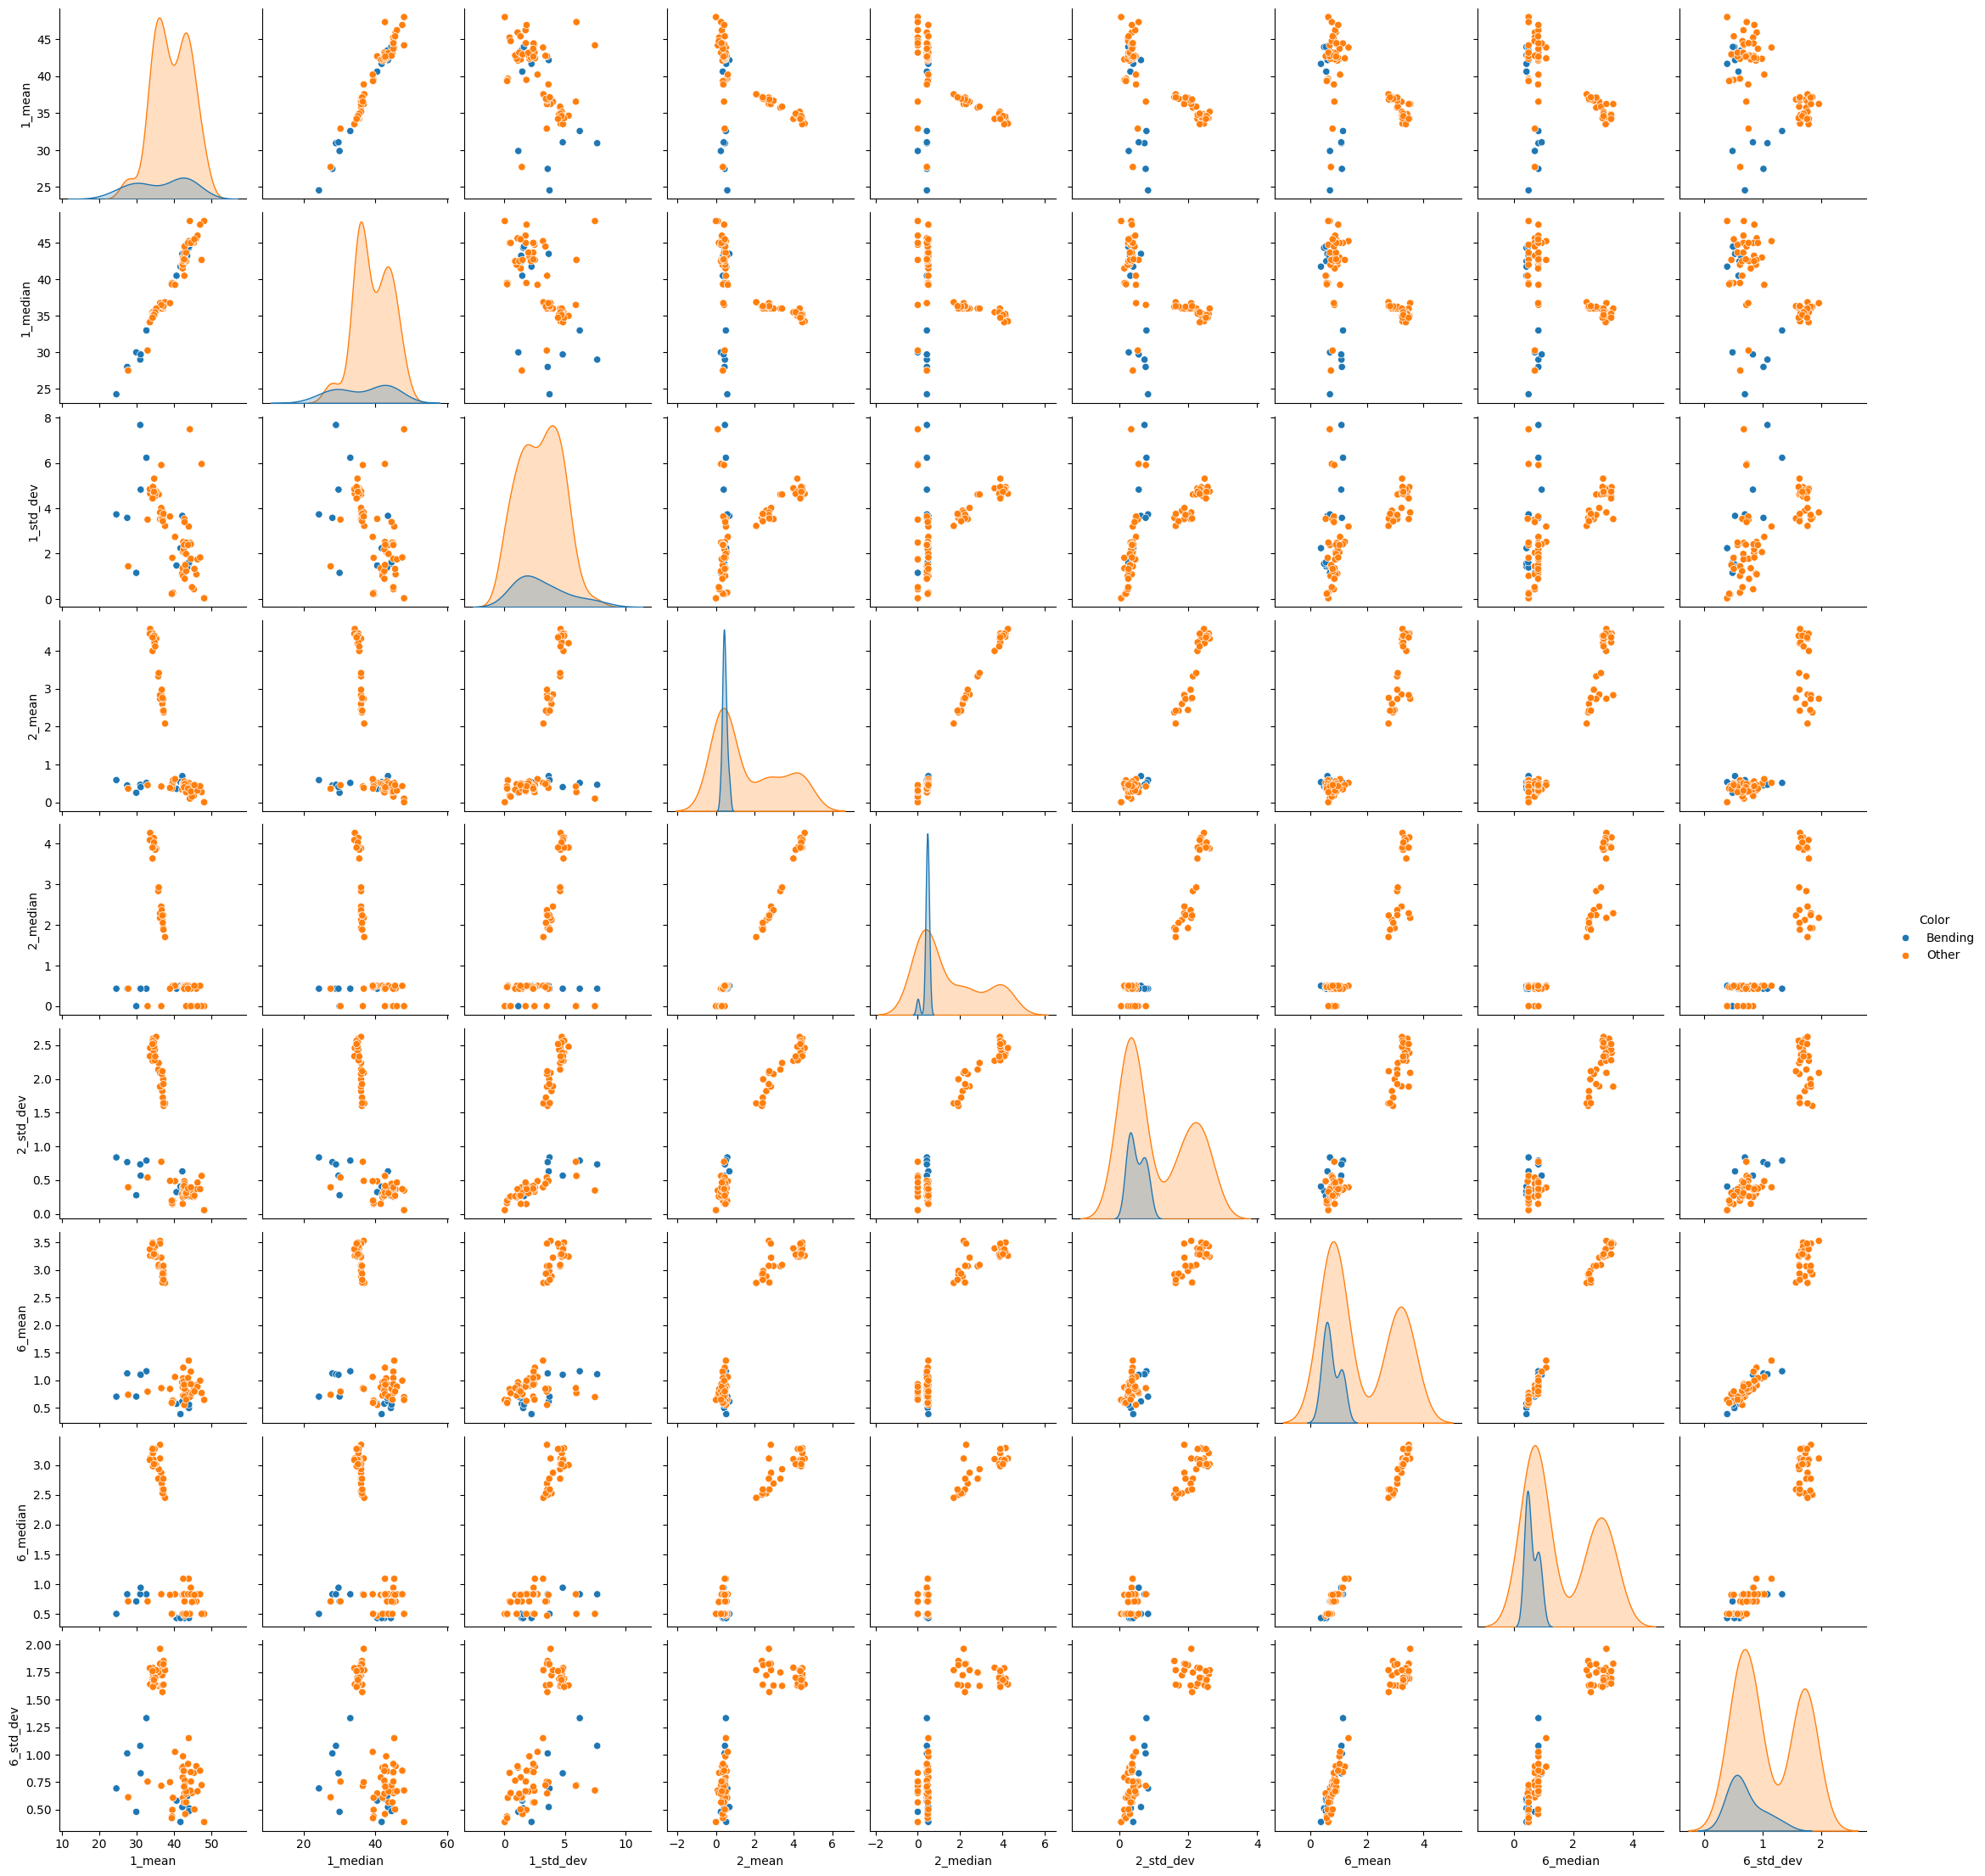

In [9]:
sns.pairplot(filtered_summary, hue='Color')

ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [10]:
def calculate_time_domain_features(data, num_segments):
    # Calculate the length of each segment
    segment_length = len(data) // num_segments

    features = {}
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = (i + 1) * segment_length

        # Extract the segment
        segment = data[start_idx:end_idx]

        # Calculate mean, median, and std_dev for each segment
        features[f'mean_part{i + 1}'] = np.mean(segment)
        features[f'median_part{i + 1}'] = np.median(segment)
        features[f'std_dev_part{i + 1}'] = np.std(segment)

    return features

In [11]:
summary_df2 = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    if activity.startswith('bending1'):
        start_file, end_file = 3, 7
    elif activity.startswith('bending2'):
        start_file, end_file = 3, 6
    else:
        start_file, end_file = 4, 15
        
    for i in range(start_file, end_file + 1):
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)

        for j in [1,2,6]:
            features = calculate_time_domain_features(df.iloc[:, j],2)
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df2.loc[len(summary_df2)] = row

# Pivoting the DataFrame and setting 'Dataset' as the index
summary_pivot2 = summary_df2.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()

# Display the pivoted summary table
summary_pivot2

Feature_Raw Data            Dataset  1_mean_part1  1_mean_part2  \
0                 bending1_dataset3     44.057167     43.851833   
1                 bending1_dataset4     43.278875     41.080750   
2                 bending1_dataset5     41.621208     41.734917   
3                 bending1_dataset6     44.117042     42.792875   
4                 bending1_dataset7     43.486208     44.452042   
..                              ...           ...           ...   
64                 walking_dataset5     34.966250     34.560417   
65                 walking_dataset6     34.737042     35.134583   
66                 walking_dataset7     33.886458     34.779625   
67                 walking_dataset8     34.836458     34.363292   
68                 walking_dataset9     34.329333     34.122417   

Feature_Raw Data  1_median_part1  1_median_part2  1_std_dev_part1  \
0                         44.500          43.500         1.553724   
1                         45.000          42.000         3.466111   
2                         42.330          41.500         3.112140   
3                         45.000          42.670         1.357000   
4                         43.710          44.500         1.279302   
..                           ...             ...              ...   
64                        35.500          35.000         4.723143   
65                        35.500          35.585         4.267798   
66                        34.375          35.000         5.133048   
67                        35.750          35.000         4.858937   
68                        34.710          34.750         4.540348   

Feature_Raw Data  1_std_dev_part2  2_mean_part1  2_mean_part2  2_median_part1  \
0                        1.553920      0.381042      0.471458           0.470   
1                        3.530103      0.673292      0.718792           0.485   
2                        0.594677      0.623083      0.448875           0.500   
3                        1.056584      0.250042      0.506125           0.000   
4                        1.767557      0.378667      0.447583           0.470   
..                            ...           ...           ...             ...   
64                       4.742673      4.207958      4.239625           3.900   
65                       4.978609      4.217333      4.014167           4.030   
66                       4.704418      4.332208      4.461708           3.900   
67                       4.578773      4.257750      4.539917           3.770   
68                       4.329060      4.315917      4.393083           3.880   

Feature_Raw Data  2_median_part2  2_std_dev_part1  2_std_dev_part2  \
0                          0.500         0.328853         0.341632   
1                          0.500         0.632962         0.626606   
2                          0.500         0.488574         0.272481   
3                          0.500         0.313444         0.260217   
4                          0.500         0.283841         0.235002   
..                           ...              ...              ...   
64                         3.960         2.327077         2.222881   
65                         3.670         2.332883         2.328307   
66                         3.935         2.447995         2.677251   
67                         4.075         2.507393         2.556266   
68                         4.025         2.465114         2.566013   

Feature_Raw Data  6_mean_part1  6_mean_part2  6_median_part1  6_median_part2  \
0                     0.598250      0.388333           0.500           0.000   
1                     0.640958      0.586083           0.765           0.470   
2                     0.419083      0.347500           0.430           0.430   
3                     0.815417      0.543875           0.710           0.500   
4                     0.524875      0.585750           0.470           0.500   
..                         ...           ...             ...            

In [12]:
summary_pivot2['Color'] = summary_pivot2['Dataset'].apply(lambda x: 'Bending' if 'bending' in x else 'Other')

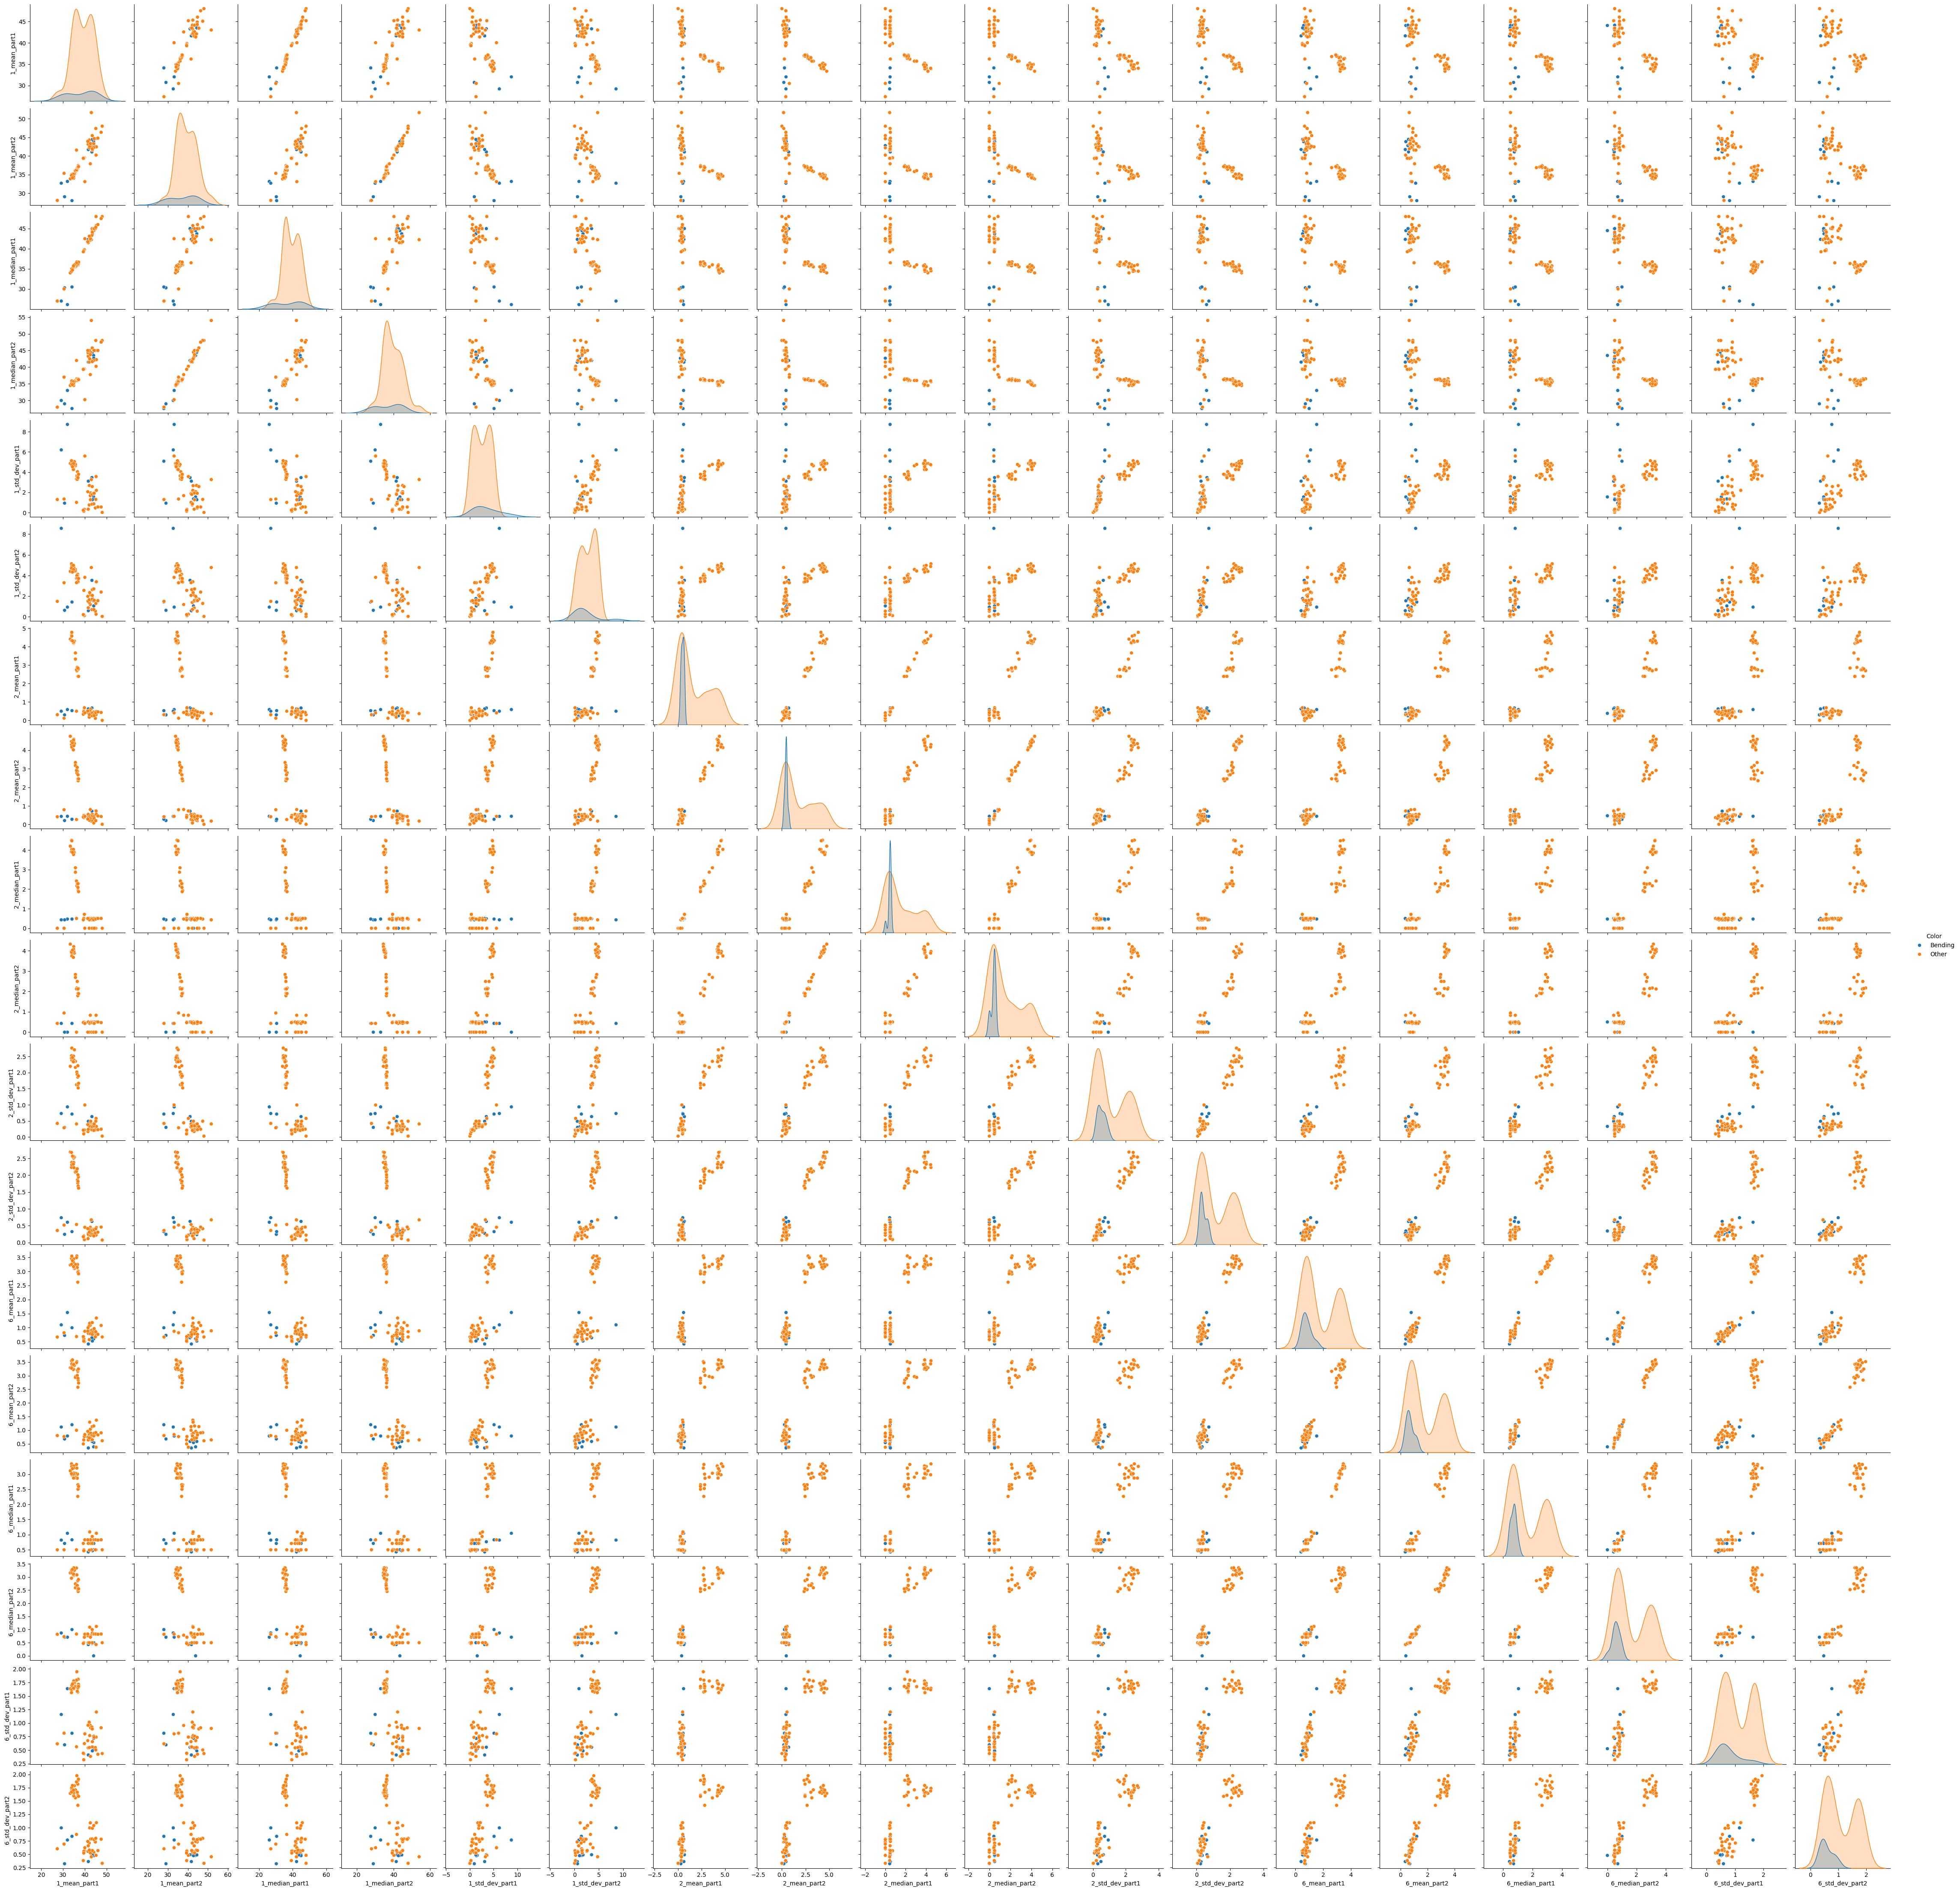

In [13]:
sns.pairplot(summary_pivot2, hue='Color')

iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
of approximately equal length and use logistic regression5
to solve the binary
classification problem, using time-domain features. Remember that breaking
each of the time series does not change the number of instances. It only
changes the number of features for each instance. Calculate the p-values for
your logistic regression parameters in each model corresponding to each value
of l and refit a logistic regression model using your pruned set of features.6
Alternatively, you can use backward selection using sklearn.feature selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(l, p), where p is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation
in this problem.7 Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use stratified cross
validation. Research what it means and use it if needed.
In the following, you can see an example of applying Python’s Recursive
Feature Elimination, which is a backward selection algorithm, to logistic regression.


In [14]:
summary_df3 = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    if activity.startswith('bending1'):
        start_file, end_file = 3, 7
    elif activity.startswith('bending2'):
        start_file, end_file = 3, 6
    else:
        start_file, end_file = 4, 15
        
    for i in range(start_file, end_file + 1):
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)

        for j in range(1,7):
            features = calculate_time_domain_features(df.iloc[:, j], 20)
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df3.loc[len(summary_df3)] = row

summary_pivot3 = summary_df3.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()
summary_pivot3['Bending'] = summary_pivot3['Dataset'].apply(lambda x: 1 if 'bending' in x else 0)
summary_pivot3

Feature_Raw Data            Dataset  1_mean_part1  1_mean_part10  \
0                 bending1_dataset3     43.513750      44.569583   
1                 bending1_dataset4     44.097083      43.461667   
2                 bending1_dataset5     41.563750      42.555000   
3                 bending1_dataset6     44.756667      42.514583   
4                 bending1_dataset7     42.951250      43.805833   
..                              ...           ...            ...   
64                 walking_dataset5     34.902917      34.625417   
65                 walking_dataset6     34.423750      36.150000   
66                 walking_dataset7     34.336250      34.659583   
67                 walking_dataset8     36.288333      33.020833   
68                 walking_dataset9     34.604167      33.749583   

Feature_Raw Data  1_mean_part11  1_mean_part12  1_mean_part13  1_mean_part14  \
0                     44.740833      44.618333      44.031250      43.492917   
1                     41.972500      41.600417      41.032500      40.083333   
2                     42.913333      41.742500      42.090000      41.510417   
3                     43.798750      42.405833      42.503333      42.716667   
4                     46.385417      44.061667      44.390000      44.507500   
..                          ...            ...            ...            ...   
64                    35.673750      34.315833      36.031250      34.868333   
65                    34.705000      36.270833      35.746250      36.083333   
66                    33.871667      35.378333      33.222500      33.854167   
67                    34.702083      34.578750      34.576667      34.531250   
68                    34.274583      33.492917      34.951250      33.656250   

Feature_Raw Data  1_mean_part15  1_mean_part16  1_mean_part17  ...  \
0                     44.027500      44.947083      43.215833  ...   
1                     40.931250      41.194583      41.537917  ...   
2                     41.682500      41.656667      41.500000  ...   
3                     44.101250      42.201250      42.645833  ...   
4                     44.580000      41.937083      44.250000  ...   
..                          ...            ...            ...  ...   
64                    35.149583      33.852917      35.003750  ...   
65                    34.673750      32.812500      35.527917  ...   
66                    34.555833      36.701667      34.958333  ...   
67                    34.722083      34.132083      33.472917  ...   
68                    34.531250      33.583333      34.139167  ...   

Feature_Raw Data  6_std_dev_part2  6_std_dev_part20  6_std_dev_part3  \
0                        0.537800          0.331457         0.496713   
1                        0.467609          0.379385         0.458943   
2                        0.304492          0.312787         0.308797   
3                        0.636710          0.934019         0.528775   
4                        0.642456          0.463747         0.284444   
..                            ...               ...              ...   
64                       1.722159          1.653925         1.410305   
65                       1.966857          1.528393         2.184214   
66                       1.576228          1.983491         1.739053   
67                       1.307089          1.738691         1.409687   
68                       1.703839          1.201672         1.858864   

Feature_Raw Data  6_std_dev_part4  6_std_dev_part5  6_std_dev_part6  \
0                        0.337595         0.323477         0.505698   
1                        0.563766         0.518695         0.514869   
2                        0.438710         0.431286         0.365667   
3                        0.571409         1.242514         0.400638   
4                        0.531766         0.458965         0.322977   
..                            ...              ...              ...   
64                 

In [15]:
y_2a3=summary_pivot3.iloc[:,-1]
y_2a3

0     1
1     1
2     1
3     1
4     1
     ..
64    0
65    0
66    0
67    0
68    0
Name: Bending, Length: 69, dtype: int64

In [16]:
for i in range(20):
    selected_columns = [col for col in summary_pivot3.columns if col.endswith(f'part{i+1}')]
    X_selected = summary_pivot3[selected_columns]
    X_selected = sm.add_constant(X_selected)
    log_reg = sm.Logit(y_2a3, X_selected)
    result = log_reg.fit(disp=0, maxiter=15)
    df_p = pd.DataFrame(result.pvalues)
    print(f"Summary table for i={i+1}:")
    print(result.summary())


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Summary table for i=1:
                           Logit Regression Results                           
Dep. Variable:                Bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        19:36:35   Log-Likelihood:            -4.5868e-05
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.246e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              49.8998   4242.289      0.012      0.991   -8264.834    8364.634
1_mean_part1      -43.7062   1300.051     -0.034      0.973   -2591.760    2504.347
1_median_

                           Logit Regression Results                           
Dep. Variable:                Bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        19:36:36   Log-Likelihood:            -5.3391e-05
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.246e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -117.8599   6892.120     -0.017      0.986   -1.36e+04    1.34e+04
1_mean_part4       16.6100   1388.546      0.012      0.990   -2704.890    2738.110
1_median_part4    -16.1248   136

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Summary table for i=8:
                           Logit Regression Results                           
Dep. Variable:                Bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        19:36:36   Log-Likelihood:            -0.00015645
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.247e-05
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              59.0162   1865.833      0.032      0.975   -3597.948    3715.981
1_mean_part8      -27.2583   1237.267     -0.022      0.982   -2452.256    2397.740
1_median_

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Summary table for i=14:
                           Logit Regression Results                           
Dep. Variable:                Bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        19:36:36   Log-Likelihood:            -3.6650e-05
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.246e-05
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               84.6117   4249.911      0.020      0.984   -8245.062    8414.285
1_mean_part14       -0.9944   1341.020     -0.001      0.999   -2629.346    2627.357
1_me

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

                           Logit Regression Results                           
Dep. Variable:                Bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           18
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        19:36:36   Log-Likelihood:            -7.5284e-05
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.246e-05
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               32.2127   2633.021      0.012      0.990   -5128.414    5192.839
1_mean_part19       17.1359   1511.266      0.011      0.991   -2944.890    2979.162
1_median_part19    -19.9576 

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CV - Find the best (l,p)

In [17]:
def select_features(X, y, p):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LogisticRegression(max_iter=100)

        selector = RFE(model, n_features_to_select=p)
        X_train_rfe = selector.fit_transform(X_train, y_train)
        X_test_rfe = X_test[X_train.columns[selector.support_]]

        selector_support=selector.support_

        model.fit(X_train_rfe, y_train)
        y_pred = model.predict(X_test_rfe)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = sum(accuracies) / len(accuracies)

    return mean_accuracy, selector_support


In [18]:
best_accuracy = 0
best_i, best_p, best_selector_support = None, None, None

for i in range(20):
    selected_columns = [col for col in summary_pivot3.columns if col.endswith(f'part{i+1}')]
    X_selected = summary_pivot3[selected_columns]

    for p in range(1, 19):
        mean_accuracy, selector_support = select_features(X_selected, y_2a3, p)

        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_i, best_p, best_selector_support  = i + 1, p, selector_support

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\App

In [19]:
print("Best (i, p) pair:", (best_i, best_p))
print("Best accuracy:", best_accuracy)
print("Best features:", best_selector_support)

train_columns = summary_pivot3[[col for col in summary_pivot3.columns if col.endswith(f'part2')]]
train_columns.columns[best_selector_support]

Best (i, p) pair: (2, 3)
Best accuracy: 0.9857142857142858
Best features: [False False False False False False False False  True False False False
  True  True False False False False]


Index(['3_std_dev_part2', '5_mean_part2', '5_median_part2'], dtype='object', name='Feature_Raw Data')

**Explain what the right way and the wrong way are to perform cross-validation in this problem.**<br><br>
Right way: Parameter Selection within Cross-Validation<br>
In the right approach, the model's hyperparameters, including the parameter l that determines the number of features, should be selected within each fold of the cross-validation.<br><br>
Wrong Way to Perform Cross-Validation: Parameter Selection before Cross-Validation<br>
In the wrong approach, selecting l before cross-validation could lead to data leakage and overfitting. For example, if l is chosen based on the entire dataset before cross-validation, the model may inadvertently learn information from the validation set.

iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi ’s as well as the p-values associated with them.

In [20]:
best_i, best_p =  2, 3
X_selected4 = summary_pivot3[['3_std_dev_part2', '5_mean_part2', '5_median_part2']]
X_selected4

Feature_Raw Data  3_std_dev_part2  5_mean_part2  5_median_part2
0                        0.277966     36.024167          36.000
1                        2.106040     36.824583          37.000
2                        7.274649     28.968750          29.750
3                        3.454708     24.472083          24.000
4                        1.962094     23.083333          21.290
..                            ...           ...             ...
64                       3.708318     17.350833          17.460
65                       3.220764     16.146667          16.250
66                       1.965759     15.782500          16.000
67                       3.568315     15.763750          15.125
68                       2.790916     16.270833          16.625

[69 rows x 3 columns]

True Negatives:

 60
False Positives: 0
False Negatives: 2
True Positives: 7
Sensitivity: 0.7777777777777778
Specificity: 1.0
AUC: 0.99


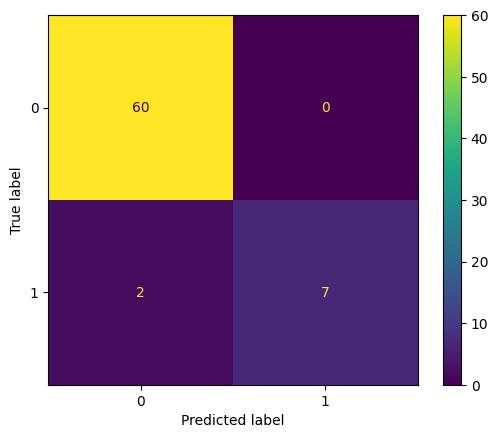

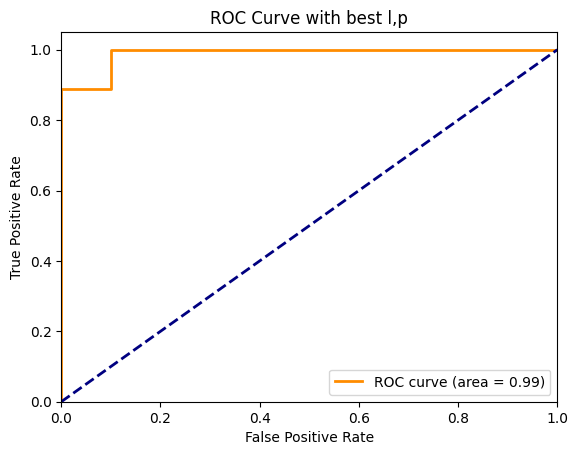

In [21]:
log_reg_best = LogisticRegression() 
log_reg_best.fit(X_selected4, y_2a3)

y_probs = log_reg_best.predict_proba(X_selected4)[:, 1]
y_pred = log_reg_best.predict(X_selected4)

fpr, tpr, thresholds = roc_curve(y_2a3, y_probs)

cnf_matrix = confusion_matrix(y_2a3, y_pred)
metrics.ConfusionMatrixDisplay(cnf_matrix).plot()
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TP = cnf_matrix[1,1]
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
print('True Positives:', TP)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN + FP)
print('Sensitivity:', Sensitivity)
print('Specificity:', Specificity)

roc_auc = roc_auc_score(y_2a3, y_probs)

print("AUC:", round(roc_auc,2))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with best l,p')
plt.legend(loc="lower right")
plt.show()

In [22]:
X_selected4 = sm.add_constant(X_selected4)
log_reg_best_stat = sm.Logit(y_2a3, X_selected4)
result_best = log_reg_best_stat.fit(disp=0, maxiter=50)

coefficients = result_best.params
p_values = result_best.pvalues

coef_pval_df = pd.DataFrame({'Coefficient (βi)': coefficients, 'P-value': p_values})
coef_pval_df = coef_pval_df.drop('const') 

print("Logistic Regression Coefficients and P-values:")
print(coef_pval_df)

Logistic Regression Coefficients and P-values:
                 Coefficient (βi)   P-value
3_std_dev_part2          1.431448  0.301620
5_mean_part2             5.503791  0.339655
5_median_part2          -3.547103  0.438846


v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [23]:
test_summary_df = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

for activity, path in dataset_paths.items():
    if activity.startswith('bending1'):
        start_file, end_file = 1, 2
    elif activity.startswith('bending2'):
        start_file, end_file = 1, 2
    else:
        start_file, end_file = 1, 3

    for i in range(start_file, end_file + 1):
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)

        for j in range(1, 7):
            features = calculate_time_domain_features(df.iloc[:, j], 20)
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                test_summary_df.loc[len(test_summary_df)] = row

test_summary_pivot = test_summary_df.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()
test_summary_pivot['Bending'] = test_summary_pivot['Dataset'].apply(lambda x: 1 if 'bending' in x else 0)
X_selected_test = test_summary_pivot[['3_std_dev_part2', '5_mean_part2', '5_median_part2']]

In [24]:
y_test = test_summary_pivot['Bending']
y_pred_test = log_reg_best.predict(X_selected_test) 
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on the Test Set:", round(accuracy_test, 2))
print("Cross-Validation Accuracy:", round(best_accuracy, 2))

Accuracy on the Test Set: 0.89
Cross-Validation Accuracy: 0.99


vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes. In question iii, the linear-separated problem cause the NAN in parameters and singular matrix problems. I tuned the maxiter to solve this problem.

vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model

Yes, there are too many negative values.

In [25]:
resampled_data = resample(summary_pivot3[summary_pivot3['Bending'] == 0],
                          replace=False, 
                          n_samples=np.sum(y_2a3 == 1), 
                          random_state=42)

balanced_data = pd.DataFrame(np.vstack((resampled_data, summary_pivot3[summary_pivot3['Bending'] == 1])))
balanced_data.columns=summary_pivot3.columns

X_balanced = balanced_data.iloc[:,1:-1]
y_balanced = balanced_data.iloc[:,-1].astype(int)

In [26]:
best_accuracy2 = 0
best_i2, best_p2, best_selector_support = None, None, None

for i in range(20):
    selected_columns = [col for col in balanced_data.columns if col.endswith(f'part{i+1}')]
    X_selected7 = balanced_data[selected_columns]

    for p in range(1, 19):
        mean_accuracy2, selector_support2 = select_features(X_selected7, y_balanced, p)

        if mean_accuracy2 > best_accuracy2:
            best_accuracy2 = mean_accuracy2
            best_i2, best_p2, best_selector_support2  = i + 1, p, selector_support2

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\App

In [27]:
print("Best (i, p) pair with balance data:", (best_i2, best_p2))
print("Best accuracy with balance data:", best_accuracy2)
print("Best features with balance data:", best_selector_support2)

train_columns2 = balanced_data[[col for col in summary_pivot3.columns if col.endswith(f'part{best_i2}')]]
train_columns2.columns[best_selector_support2]

Best (i, p) pair with balance data: (2, 2)
Best accuracy with balance data: 1.0
Best features with balance data: [False False  True False False False False False False False False False
  True False False False False False]


Index(['1_std_dev_part2', '5_mean_part2'], dtype='object', name='Feature_Raw Data')

In [28]:
X_selected7 = balanced_data[['1_std_dev_part2', '5_mean_part2']]
X_selected7

Feature_Raw Data 1_std_dev_part2 5_mean_part2
0                       3.556095    16.968333
1                       3.710147    19.519167
2                       1.887112     7.246667
3                       0.652389    14.340417
4                            0.0         2.09
5                       4.635842    17.472083
6                       0.904579    12.390417
7                       4.328366    15.332917
8                       0.233621     9.235833
9                       0.393213    36.024167
10                      3.291842    36.824583
11                      2.089784     28.96875
12                      0.138193    24.472083
13                      1.189117    23.083333
14                      0.704018     25.34375
15                      0.377256       18.205
16                      0.123252    19.489583
17                       1.08517    28.923333

True Negatives: 9
False Positives: 0
False Negatives: 0
True Positives: 9
Sensitivity: 1.0
Specificity: 1.0


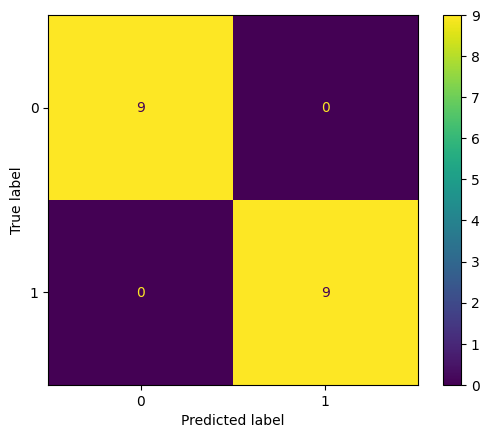

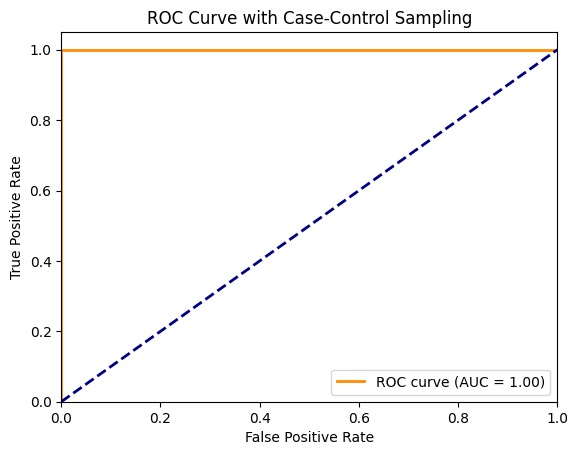

In [29]:
log_reg_balanced2 = LogisticRegression()
log_reg_balanced2.fit(X_selected7, y_balanced)

y_probs_balanced = log_reg_balanced2.predict_proba(X_selected7)[:, 1]
y_pred_balanced = log_reg_balanced2.predict(X_selected7)

conf_matrix_balanced = confusion_matrix(y_balanced, y_pred_balanced)
roc_auc_balanced = roc_auc_score(y_balanced, y_probs_balanced)

metrics.ConfusionMatrixDisplay(conf_matrix_balanced).plot()
TN = conf_matrix_balanced[0,0]
FP = conf_matrix_balanced[0,1]
FN = conf_matrix_balanced[1,0]
TP = conf_matrix_balanced[1,1]
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)
print('True Positives:', TP)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN + FP)
print('Sensitivity:', Sensitivity)
print('Specificity:', Specificity)

# Plot ROC curve
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_balanced, y_probs_balanced)
plt.figure()
plt.plot(fpr_balanced, tpr_balanced, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_balanced)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Case-Control Sampling')
plt.legend(loc="lower right")
plt.show()

**(b) Binary Classification Using L1-penalized logistic regression**<br>
i. Repeat 2(a)iii using L1-penalized logistic regression,8
i.e. instead of using p values for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically.<br>


In [30]:
summary_df_nrm = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    if activity.startswith('bending1'):
        start_file, end_file = 3, 7
    elif activity.startswith('bending2'):
        start_file, end_file = 3, 6
    else:
        start_file, end_file = 4, 15
        
    for i in range(start_file, end_file + 1):
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)
        scaler = MinMaxScaler()
        df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

        for j in range(1,7):
            features = calculate_time_domain_features(df.iloc[:, j], 20)
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df_nrm.loc[len(summary_df_nrm)] = row

summary_pivot_nrm = summary_df_nrm.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()
summary_pivot_nrm['Bending'] = summary_pivot_nrm['Dataset'].apply(lambda x: 1 if 'bending' in x else 0)
summary_pivot_nrm

Feature_Raw Data            Dataset  1_mean_part1  1_mean_part10  \
0                 bending1_dataset3      0.686593       0.771741   
1                 bending1_dataset4      0.752345       0.709266   
2                 bending1_dataset5      0.671667       0.749412   
3                 bending1_dataset6      0.705152       0.501326   
4                 bending1_dataset7      0.570319       0.643050   
..                              ...           ...            ...   
64                 walking_dataset5      0.555016       0.544134   
65                 walking_dataset6      0.438093       0.496610   
66                 walking_dataset7      0.545544       0.556564   
67                 walking_dataset8      0.654936       0.535771   
68                 walking_dataset9      0.678174       0.647838   

Feature_Raw Data  1_mean_part11  1_mean_part12  1_mean_part13  1_mean_part14  \
0                      0.785551       0.775672       0.728327       0.684913   
1                      0.608305       0.583079       0.544576       0.480226   
2                      0.777516       0.685686       0.712941       0.667484   
3                      0.618068       0.491439       0.500303       0.519697   
4                      0.862589       0.664823       0.692766       0.702766   
..                          ...            ...            ...            ...   
64                     0.585245       0.531993       0.599265       0.553660   
65                     0.447627       0.500706       0.482924       0.494350   
66                     0.529709       0.581061       0.507584       0.529113   
67                     0.597085       0.592588       0.592512       0.590855   
68                     0.666474       0.638726       0.690495       0.644524   

Feature_Raw Data  1_mean_part15  1_mean_part16  1_mean_part17  ...  \
0                      0.728024       0.802184       0.662567  ...   
1                      0.537712       0.555565       0.578842  ...   
2                      0.680980       0.678954       0.666667  ...   
3                      0.645568       0.472841       0.513258  ...   
4                      0.708936       0.484007       0.680851  ...   
..                          ...            ...            ...  ...   
64                     0.564690       0.513840       0.558971  ...   
65                     0.446568       0.383475       0.475523  ...   
66                     0.553028       0.626165       0.566746  ...   
67                     0.597815       0.576298       0.552258  ...   
68                     0.675586       0.641936       0.661667  ...   

Feature_Raw Data  6_std_dev_part2  6_std_dev_part20  6_std_dev_part3  \
0                        0.300447          0.185172         0.277493   
1                        0.214500          0.174030         0.210524   
2                        0.170107          0.174741         0.172512   
3                        0.121047          0.177570         0.100527   
4                        0.217046          0.156671         0.096096   
..                            ...               ...              ...   
64                       0.183404          0.176137         0.150192   
65                       0.192640          0.149696         0.213929   
66                       0.196783          0.247627         0.217110   
67                       0.147527          0.196241         0.159107   
68                       0.180875          0.127566         0.197332   

Feature_Raw Data  6_std_dev_part4  6_std_dev_part5  6_std_dev_part6  \
0                        0.188601         0.180713         0.282513   
1                        0.258608         0.237933         0.236178   
2                        0.245089         0.240942         0.204283   
3                        0.108633         0.236219         0.076167   
4                        0.179651         0.155056         0.109114   
..                            ...              ...              ...   
64                 

In [31]:
summary_df_nrm_test = pd.DataFrame(columns=['Dataset', 'Feature_Raw Data', 'Value'])

# Process each dataset
for activity, path in dataset_paths.items():
    if activity.startswith('bending1'):
        start_file, end_file = 1, 2
    elif activity.startswith('bending2'):
        start_file, end_file = 1, 2
    else:
        start_file, end_file = 1, 3
        
    for i in range(start_file, end_file + 1):
        file_path = os.path.join(path, f'dataset{i}.csv')
        df = pd.read_csv(file_path, skiprows=4, header=0)
        scaler = MinMaxScaler()
        df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

        for j in range(1,7):
            features = calculate_time_domain_features(df.iloc[:, j], 20)
            for feature_name, value in features.items():
                row = [f'{activity}_dataset{i}', f'{j}_{feature_name}', value]
                summary_df_nrm_test.loc[len(summary_df_nrm_test)] = row

summary_pivot_nrm_test = summary_df_nrm_test.pivot(index='Dataset', columns='Feature_Raw Data', values='Value').reset_index()
summary_pivot_nrm_test['Bending'] = summary_pivot_nrm_test['Dataset'].apply(lambda x: 1 if 'bending' in x else 0)
summary_pivot_nrm_test

Feature_Raw Data            Dataset  1_mean_part1  1_mean_part10  \
0                 bending1_dataset1      0.312742       0.353495   
1                 bending1_dataset2      0.708985       0.531019   
2                 bending2_dataset1      0.174379       0.334521   
3                 bending2_dataset2      0.631335       0.706618   
4                  cycling_dataset1      0.571446       0.675080   
5                  cycling_dataset2      0.531667       0.576849   
6                  cycling_dataset3      0.701809       0.662164   
7                    lying_dataset1      0.838141       0.470641   
8                    lying_dataset2      0.183171       0.986005   
9                    lying_dataset3      0.000000       0.041667   
10                 sitting_dataset1      0.591808       0.686215   
11                 sitting_dataset2      0.762879       0.700273   
12                 sitting_dataset3      0.435185       0.268333   
13                standing_dataset1      0.895166       0.756703   
14                standing_dataset2      0.650775       0.855620   
15                standing_dataset3      0.841637       0.887164   
16                 walking_dataset1      0.629413       0.609226   
17                 walking_dataset2      0.683462       0.674154   
18                 walking_dataset3      0.568005       0.610564   

Feature_Raw Data  1_mean_part11  1_mean_part12  1_mean_part13  1_mean_part14  \
0                      0.266344       0.241882       0.223118       0.237419   
1                      0.525587       0.374837       0.445839       0.302423   
2                      0.301471       0.229314       0.241558       0.272331   
3                      0.692973       0.649201       0.628899       0.529561   
4                      0.633695       0.610602       0.648273       0.692410   
5                      0.557943       0.490755       0.552292       0.596146   
6                      0.662733       0.679275       0.624302       0.685579   
7                      0.487179       0.493590       0.488846       0.517692   
8                      0.988055       0.986005       0.986005       0.986005   
9                      0.000000       0.000000       0.000000       0.000000   
10                     0.698220       0.693277       0.691384       0.691186   
11                     0.697000       0.692727       0.693697       0.661364   
12                     0.385926       0.325556       0.263889       0.217593   
13                     0.832368       0.816093       0.496989       0.551948   
14                     0.832829       0.844961       0.694961       0.331705   
15                     0.900117       0.898743       0.768772       0.641813   
16                     0.586936       0.574352       0.607916       0.660823   
17                     0.651385       0.645090       0.648397       0.607269   
18                     0.599948       0.594803       0.629029       0.769685   

Feature_Raw Data  1_mean_part15  1_mean_part16  1_mean_part17  ...  \
0                      0.246882       0.276075       0.430108  ...   
1                      0.739298       0.856964       0.833007  ...   
2                      0.285948       0.300654       0.349325  ...   
3                      0.669756       0.593645       0.562622  ...   
4                      0.638213       0.640562       0.623494  ...   
5                      0.527266       0.520599       0.532109  ...   
6                      0.659370       0.678999       0.639005  ...   
7                      0.728077       0.862244       0.865385  ...   
8                      0.986005       0.986005       0.986005  ...   
9                      0.000000       0.125000       0.041667  ...   
10                     0.647119       0.640056       0.648531  ...   
11                     0.676273       0.623273       0.640667  ...   
12                     0.222222       0.222222       0.226852  ...   
13                     0.591002       0.643575       0.602

In [32]:
def select_features_l1(X, y, p, lambda_val):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LogisticRegression(max_iter=100, penalty='l1', solver='liblinear', C=lambda_val)

        selector = RFE(model, n_features_to_select=p)
        X_train_rfe = selector.fit_transform(X_train, y_train)
        X_test_rfe = X_test[X_train.columns[selector.support_]]

        selector_support=selector.support_

        model.fit(X_train_rfe, y_train)
        y_pred = model.predict(X_test_rfe)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = sum(accuracies) / len(accuracies)

    return mean_accuracy, selector_support

In [33]:
l_values = range(1, 21)
lambdas = [0.01, 0.1, 1.0, 10.0]
p_values = range(1, 19)

In [34]:
best_accuracy_nrm = 0
best_i_nrm, best_p_nrm, best_c, best_selector_support_nrm = None, None, None, None

for i in range(20):
    selected_columns = [col for col in summary_pivot_nrm.columns if col.endswith(f'part{i+1}')]
    X_selected_nrm = summary_pivot_nrm[selected_columns]

    for p in range(1, 19):
        for lambda_val in lambdas:  
            mean_accuracy, selector_support = select_features_l1(X_selected_nrm, y_2a3, p, lambda_val)

            if mean_accuracy > best_accuracy_nrm:
                best_accuracy_nrm = mean_accuracy
                best_i_nrm, best_p_nrm, best_selector_support_nrm  = i + 1, p, selector_support
                best_c=lambda_val

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\App

In [35]:
print("Best (i, p) pair:", (best_i_nrm, best_p_nrm))
print("Best accuracy:", best_accuracy_nrm)
print("Best features:", best_selector_support_nrm)
print("Best C:", best_c)


train_columns = summary_pivot_nrm[[col for col in summary_pivot_nrm.columns if col.endswith(f'part{best_i_nrm}')]]
train_columns.columns[best_selector_support_nrm]

Best (i, p) pair: (19, 3)
Best accuracy: 0.9142857142857143
Best features: [False False False False False False  True False False False  True False
 False  True False False False False]
Best C: 10.0


Index(['3_mean_part19', '4_median_part19', '5_median_part19'], dtype='object', name='Feature_Raw Data')

ii. Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

In [36]:
X_selected_nrm2=summary_pivot_nrm[['3_mean_part19', '4_median_part19', '5_median_part19']]

X_selected_nrm2 = sm.add_constant(X_selected_nrm2)
log_reg_best_stat_l1 = sm.Logit(y_2a3, X_selected_nrm2)
result_best_l1 = log_reg_best_stat_l1.fit(disp=0, maxiter=100, C=10)

coefficients = result_best_l1.params
p_values = result_best_l1.pvalues

coef_pval_df = pd.DataFrame({'Coefficient (βi)': coefficients, 'P-value': p_values})
coef_pval_df = coef_pval_df.drop('const') 

print("Logistic Regression Coefficients and P-values (l1):")
print(coef_pval_df)

Logistic Regression Coefficients and P-values (l1):
                 Coefficient (βi)   P-value
3_mean_part19           -7.309852  0.015932
4_median_part19        -21.265306  0.005565
5_median_part19         -2.047219  0.347938


I think the L1-penalized performed better based on the P value.

(c) Multi-class Classification (The Realistic Case)

i. Find the best l in the same way as you found it in 2(b)i to build an L1-
penalized multinomial regression model to classify all activities in your training set.Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possible.

In [37]:
summary_pivot_nrm['class'] = summary_pivot_nrm['Dataset'].str.split('_').str[0]

def select_features_l1_multinomial(X, y, p, lambda_val):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LogisticRegression(max_iter=100, penalty='l1', solver='saga', C=lambda_val, multi_class='multinomial')

        selector = RFE(model, n_features_to_select=p)
        X_train_rfe = selector.fit_transform(X_train, y_train)
        X_test_rfe = X_test[X_train.columns[selector.support_]]

        selector_support = selector.support_

        model.fit(X_train_rfe, y_train)
        y_pred = model.predict(X_test_rfe)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = sum(accuracies) / len(accuracies)

    return mean_accuracy, selector_support

In [38]:
l_values = range(1, 21)
lambdas = [0.01, 0.1, 1.0, 10.0]
p_values = range(1, 19)
y_c=summary_pivot_nrm['class']

In [39]:
best_accuracy_nrm = 0
best_i_nrm, best_p_nrm, best_c, best_selector_support_nrm = None, None, None, None

for i in range(20):
    selected_columns = [col for col in summary_pivot_nrm.columns if col.endswith(f'part{i+1}')]
    X_selected_nrm = summary_pivot_nrm[selected_columns]

    for p in range(1, 19):
        for lambda_val in lambdas:  
            mean_accuracy, selector_support = select_features_l1_multinomial(X_selected_nrm, y_c, p, lambda_val)

            if mean_accuracy > best_accuracy_nrm:
                best_accuracy_nrm = mean_accuracy
                best_i_nrm, best_p_nrm, best_selector_support_nrm  = i + 1, p, selector_support
                best_c=lambda_val

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warning

In [40]:
print("Best (i, p) pair:", (best_i_nrm, best_p_nrm))
print("Best accuracy:", best_accuracy_nrm)
print("Best features:", best_selector_support_nrm)
print("Best C:", best_c)


train_columns = summary_pivot_nrm[[col for col in summary_pivot_nrm.columns if col.endswith(f'part{best_i_nrm}')]]
train_columns.columns[best_selector_support_nrm]

Best (i, p) pair: (20, 15)
Best accuracy: 0.6384615384615385
Best features: [ True  True  True  True  True  True  True  True False  True  True False
  True  True  True  True  True False]
Best C: 10.0


Index(['1_mean_part20', '1_median_part20', '1_std_dev_part20', '2_mean_part20',
       '2_median_part20', '2_std_dev_part20', '3_mean_part20',
       '3_median_part20', '4_mean_part20', '4_median_part20', '5_mean_part20',
       '5_median_part20', '5_std_dev_part20', '6_mean_part20',
       '6_median_part20'],
      dtype='object', name='Feature_Raw Data')

In [41]:
summary_pivot_nrm_test['class'] = summary_pivot_nrm_test['Dataset'].str.split('_').str[0]
y_test_c=summary_pivot_nrm_test['class']
X_test_c=summary_pivot_nrm_test[['1_mean_part20', '1_std_dev_part20', '2_mean_part20', '2_median_part20',
       '2_std_dev_part20', '3_mean_part20', '4_mean_part20', '4_median_part20',
       '5_mean_part20', '5_median_part20', '5_std_dev_part20', '6_mean_part20',
       '6_median_part20']]

X_train_c = summary_pivot_nrm[['1_mean_part20', '1_std_dev_part20', '2_mean_part20', '2_median_part20',
       '2_std_dev_part20', '3_mean_part20', '4_mean_part20', '4_median_part20',
       '5_mean_part20', '5_median_part20', '5_std_dev_part20', '6_mean_part20',
       '6_median_part20']]
y_train_c=summary_pivot_nrm['class']

model = LogisticRegression(max_iter=100, penalty='l1', solver='saga', C=10, multi_class='multinomial')
model.fit(X_train_c, y_train_c)

LogisticRegression(C=10, multi_class='multinomial', penalty='l1', solver='saga')

Accuracy on the test set: 0.5263157894736842


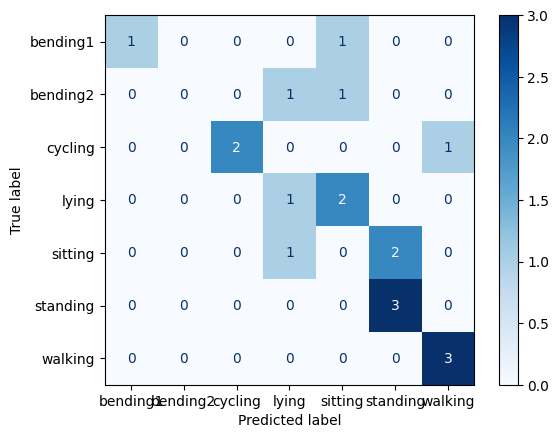

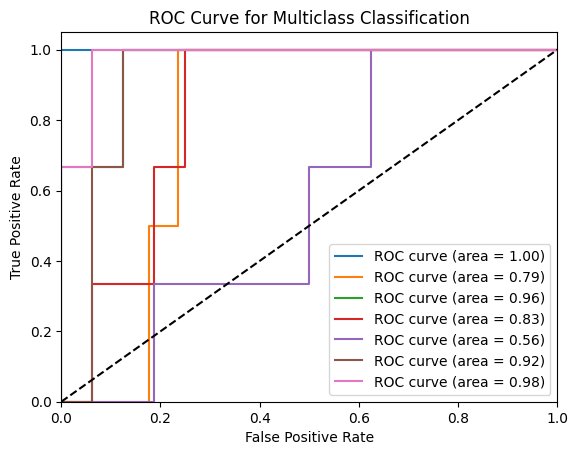

In [42]:
y_pred_c = model.predict(X_test_c)

# Calculate accuracy
accuracy = accuracy_score(y_test_c, y_pred_c)
print("Accuracy on the test set:", accuracy)

# Confusion matrix
conf_matrix_c = confusion_matrix(y_test_c, y_pred_c)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix_c, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test_bin = label_binarize(y_test_c, classes=model.classes_)

for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test_c)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results

In [43]:
def train_and_evaluate_gaussian_naive_bayes(X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_l = 0
    best_accuracy = 0
    
    for i in range(20):
        selected_columns = [col for col in summary_pivot_nrm.columns if col.endswith(f'part{i+1}')]
        X_selected = summary_pivot_nrm[selected_columns]
        accuracies = []
        
        for train_index, test_index in skf.split(X_selected, y_train):
            X_v1, X_v2 = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_v1, y_v2 = y_train.iloc[train_index], y_train.iloc[test_index]
            
            nb_gaussian = GaussianNB()
            nb_gaussian.fit(X_v1, y_v1)
            y_pred = nb_gaussian.predict(X_v2)
            
            accuracy = accuracy_score(y_v2, y_pred)
            accuracies.append(accuracy)
        
        mean_accuracy = np.mean(accuracies)
        
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_l = i + 1
    
    print("Best l for Gaussian Naïve Bayes:", best_l)
    print("Best accuracy for Gaussian Naïve Bayes:", best_accuracy)

    X_train = summary_pivot_nrm[[col for col in X_train.columns if col.endswith(f'part{i+1}')]]
    
    nb_gaussian = GaussianNB()
    nb_gaussian.fit(X_train, y_train)
    y_pred = nb_gaussian.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on the test set (Gaussian Naïve Bayes):", accuracy)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=nb_gaussian.classes_)
    disp.plot(cmap=plt.cm.Blues)
    
    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=nb_gaussian.classes_)
    
    for i in range(len(nb_gaussian.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], nb_gaussian.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure()
    for i in range(len(nb_gaussian.classes_)):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification (Gaussian Naïve Bayes)')
    plt.legend(loc="lower right")
    plt.show()

In [44]:
def train_and_evaluate_multinomial_naive_bayes(X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_l = 0
    best_accuracy = 0
    
    for i in range(20):
        selected_columns = [col for col in summary_pivot_nrm.columns if col.endswith(f'part{i+1}')]
        X_selected = summary_pivot_nrm[selected_columns]
        accuracies = []
        
        for train_index, test_index in skf.split(X_selected, y_train):
            X_v1, X_v2 = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_v1, y_v2 = y_train.iloc[train_index], y_train.iloc[test_index]
            
            nb_multinomial = MultinomialNB()
            nb_multinomial.fit(X_v1, y_v1)
            y_pred = nb_multinomial.predict(X_v2)
            
            accuracy = accuracy_score(y_v2, y_pred)
            accuracies.append(accuracy)
        
        mean_accuracy = np.mean(accuracies)
        
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_l = i + 1
    
    print("Best l for Gaussian Naïve Bayes:", best_l)
    print("Best accuracy for Gaussian Naïve Bayes:", best_accuracy)

    X_train = summary_pivot_nrm[[col for col in X_train.columns if col.endswith(f'part{i+1}')]]

    nb_multinomial = MultinomialNB()
    nb_multinomial.fit(X_train, y_train)
    y_pred = nb_multinomial.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on the test set (Multinomial Naïve Bayes):", accuracy)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=nb_multinomial.classes_)
    disp.plot(cmap=plt.cm.Blues)
    
    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=nb_multinomial.classes_)
    
    for i in range(len(nb_multinomial.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], nb_multinomial.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure()
    for i in range(len(nb_multinomial.classes_)):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification (Multinomial Naïve Bayes)')
    plt.legend(loc="lower right")
    plt.show()

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

Best l for Gaussian Naïve Bayes: 10
Best accuracy for Gaussian Naïve Bayes: 0.6395604395604396
Accuracy on the test set (Gaussian Naïve Bayes): 0.5263157894736842


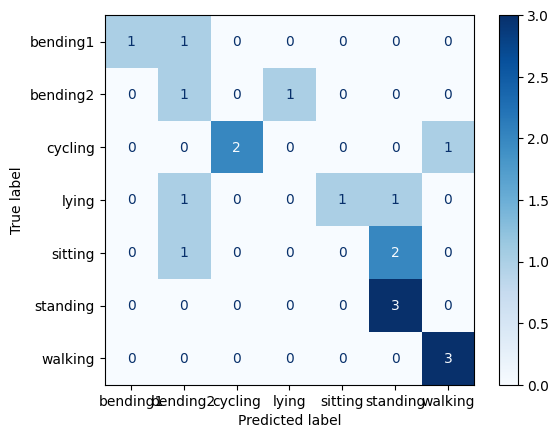

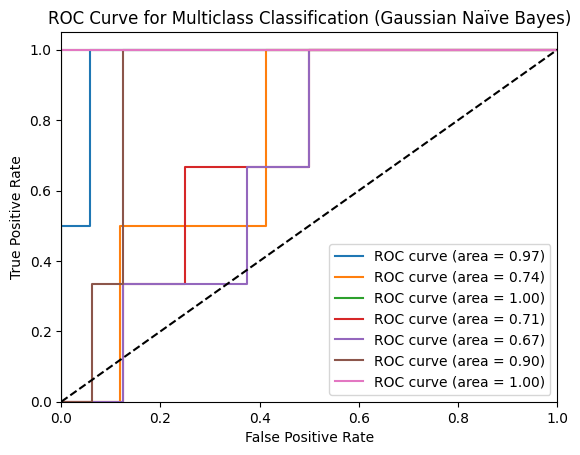

c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\云忆\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

Best l for Gaussian Naïve Bayes: 8
Best accuracy for Gaussian Naïve Bayes: 0.4351648351648351
Accuracy on the test set (Multinomial Naïve Bayes): 0.47368421052631576


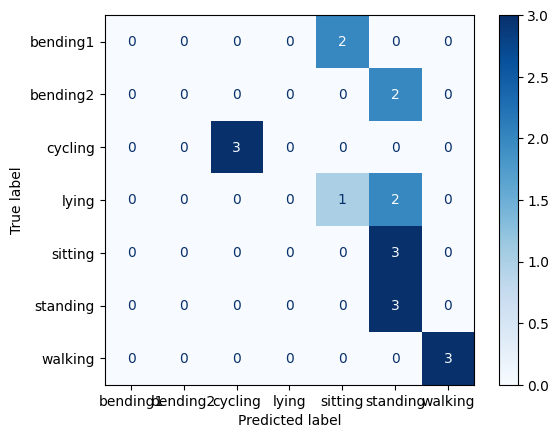

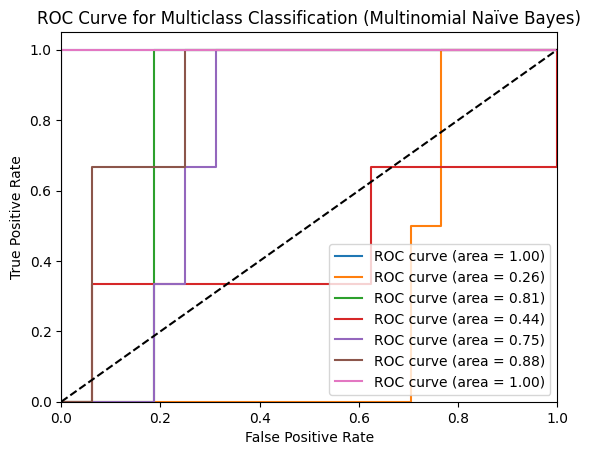

In [45]:
train_and_evaluate_gaussian_naive_bayes(X_train_c, y_train_c, X_test_c, y_test_c)
train_and_evaluate_multinomial_naive_bayes(X_train_c, y_train_c, X_test_c, y_test_c)

iii. Which method is better for multi-class classification in this problem?

Based on accracy, in this question, Multinominal Naive Bayes is the best model for multi-class classification.

# 3. ISLR, 4.8.3, 4.8.7 in PDF file 